In [1]:
from typing import Annotated

from langchain_groq import ChatGroq
from langchain_core.messages import AnyMessage, AIMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage

In [2]:
load_dotenv()

True

In [3]:
llm = ChatGroq(model="openai/gpt-oss-20b")

In [4]:
from langgraph.graph.message import add_messages
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [5]:
def chat_node(state: ChatState):

    decision = interrupt({
        "type": "approval",
        "reason": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })
    
    if decision["approved"] == 'no':
        return {"messages": [AIMessage(content="Not approved.")]}

    else:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}

In [6]:
# 3. Build the graph: START -> chat -> END
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Checkpointer is required for interrupts
checkpointer = MemorySaver()

# Compile the app
app = builder.compile(checkpointer=checkpointer)

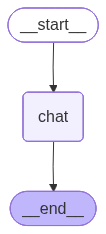

In [7]:
app

In [17]:
# Create a new thread id for this conversation
config = {"configurable": {"thread_id": '1234'}}

# ---- STEP 1: user asks a question ----
initial_input = {
    "messages": [
        ("user", "Explain gradient descent in very simple terms.")
    ]
}

# Invoke the graph for the first time
result = app.invoke(initial_input, config=config)

In [18]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='bb0f36d8-3d56-45db-91e6-6bef22fe02e8'),
  AIMessage(content='**Gradient descent** is just a way to find the bottom of a hill (or the lowest point of a curve) when you can’t see the whole shape at once.\n\n---\n\n### Think of a hill\n\n1. **You’re standing somewhere on the hill** – that point represents a possible answer to a problem (e.g., a set of numbers you’re trying to choose).\n2. **You want the lowest point** – that’s the best answer, the one that gives the smallest “error” or “cost”.\n\n---\n\n### What the algorithm does\n\n| Step | What happens | Why it helps |\n|------|--------------|--------------|\n| 1. **Pick a starting spot** | You choose some random numbers. | You need a starting point to begin searching. |\n| 2. **Look around** | You measure how steep the hill is in each direction (this is called the *gradient*). | The gradient tells you wh

In [19]:
message = result['__interrupt__'][0].value

In [20]:
user_input = input(f"\nBackend message - {message} \n Approve this question? (y/n): ")

In [21]:
# Resume the graph with the approval decision
final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config,
)

In [22]:
print(final_result["messages"][-1].content)

Not approved.
